<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Построим модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузим и подготовим данные.
2. Обучим разные модели. 
3. Сделаем выводы.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортируем необходимые библиотеки

In [1]:
#!pip install torch
#!pip install transformers
#!pip install catboost
#!pip install lightgbm
# Install spaCy (run in terminal/prompt)
#import sys
#!{sys.executable} -m pip install spacy
# Download spaCy's  'en' Model
#!{sys.executable} -m spacy download en

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords

#from nltk.stem import WordNetLemmatizer
#from nltk.corpus import wordnet
#from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords as nltk_stopwords
#nltk.download('wordnet')
#nltk.download('punkt')
#nltk.download('omw-1.4')

import spacy

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score

import re

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anton\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
try:
    comments = pd.read_csv(r'C:\Users\Anton\Desktop\YandexDisk\Practicum\мое\12 Текст\toxic_comments.csv')
except:
    comments = pd.read_csv(r'C:\Users\AdminLoc\Desktop\!YA\TEXT\toxic_comments.csv')

comments

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [4]:
#comments = comments.sample(5000)

In [5]:
print('Количество дубликатов:', comments.duplicated().sum())

Количество дубликатов: 0


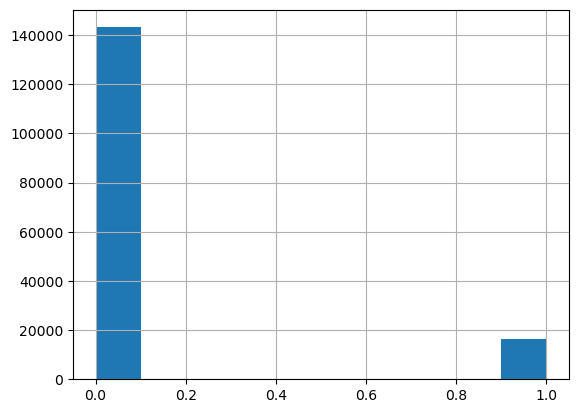

In [6]:
comments.toxic.hist();

Токсичных комментариев в разы меньше. Учтем это при обучении.

### Очистка

Очистим от лишних символов и приведем все к нижнему регистру

In [7]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = text.lower()
    text = ' '.join(text.split())
    return text

In [8]:
comments['text'] = comments['text'].apply(clear_text)

In [9]:
comments

,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,d aww he matches this background colour i m se...,0
2,2,hey man i m really not trying to edit war it s...,0
3,3,more i can t make any real suggestions on impr...,0
4,4,you sir are my hero any chance you remember wh...,0
...,...,...,...
159287,159446,and for the second time of asking when your vi...,0
159288,159447,you should be ashamed of yourself that is a ho...,0
159289,159448,spitzer umm theres no actual article for prost...,0
159290,159449,and it looks like it was actually you who put ...,0


### Лемматизация

Проведем лемматизацию текста, применим современную библиотеку spacy

In [10]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [11]:
#lemmatizer = WordNetLemmatizer()
#def lemmatize(text):
#    tokens = word_tokenize(text)
#    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in tokens])
#    return lemmatized_output

#def get_wordnet_pos(word):
#    """функция возвращает словарь, где возвращается значение часть речи (pos_tag)"""
#    tag = nltk.pos_tag([word])[0][1][0].upper()
#    tag_dict = {"J": wordnet.ADJ,
#                "N": wordnet.NOUN,
#                "V": wordnet.VERB,
#                "R": wordnet.ADV}
# 
#    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
comments['text'] = comments['text'].apply(lemmatize)

In [13]:
comments

,Unnamed: 0,text,toxic
0,0,explanation why the edit make under my usernam...,0
1,1,d aww he match this background colour I m seem...,0
2,2,hey man I m really not try to edit war it s ju...,0
3,3,more I can t make any real suggestion on impro...,0
4,4,you sir be my hero any chance you remember wha...,0
...,...,...,...
159287,159446,and for the second time of ask when your view ...,0
159288,159447,you should be ashamed of yourself that be a ho...,0
159289,159448,spitzer umm there s no actual article for pros...,0
159290,159449,and it look like it be actually you who put on...,0


### Разделение

Разделим данные на целевой признак и данные

In [14]:
comments_train, comments_test, target_train, target_test = train_test_split(
    comments['text'], 
    comments['toxic'].values, 
    test_size=0.25, 
    random_state=1,
    stratify=comments['toxic']
)

print(f'Размер обучающей выборки {comments_train.shape} {target_train.shape}, \
     \nтестовой {comments_test.shape} {target_test.shape}')

Размер обучающей выборки (119469,) (119469,),      
тестовой (39823,) (39823,)


In [15]:
del comments

### TF-IDF

In [16]:
stopwords = set(nltk_stopwords.words('english'))

In [17]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(comments_train) 
tf_idf_test = count_tf_idf.transform(comments_test) 

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (119469, 137834)
Размер матрицы: (39823, 137834)


In [18]:
del comments_train, comments_test

## Обучение

Воспользуемся моделями логистической регрессии и градиентного бустинга.
Для подбора параметров моделей будем использовать GridSearchCV.

### Функция для обучения моделей

Напишем функцию для обучения моделей

In [19]:
list_of_results = pd.DataFrame(index=['Время обучения', 'Время предсказания', 'f1'])

def learning_model(model, X, Y, grid_param=None):
        
    list = []
    name_model = type(model).__name__
    
    model = GridSearchCV(model, grid_param, scoring='f1', cv=5, n_jobs=-1)
    
    timer = time.time()
    model.fit(X, Y)
    print('GridSearchCV подбирал параметры %.2f секунд' %(time.time() - timer))
    
    results = pd.DataFrame(model.cv_results_)
    
    # Добавим в список время обучения
    list.append(results.query('mean_test_score.idxmax()')['mean_fit_time'])
    print('Время обучения модели %.2f секунд' %results.query('mean_test_score.idxmax()')['mean_fit_time'])
    
    # Добавим в список время предсказания
    list.append(results.query('mean_test_score.idxmax()')['mean_score_time'])
    print('Модель предсказывает за %.2f секунд' %results.query('mean_test_score.idxmax()')['mean_score_time'])
    
    # Добавим в список F1
    list.append(model.best_score_)
    
    print('Наилучшая F1', model.best_score_)
    print('Лучшие параметры', model.best_params_)
        
    list_of_results[name_model] = list
    
    return model.best_estimator_

### LGBMClassifier

In [20]:
%%time

lgbm_model = LGBMClassifier(random_state=1, 
                            class_weight='balanced', 
                            n_jobs=-1)

# Создадим словарь параметров
grid = {"n_estimators": [100, 200],
        "max_depth": [5, 10]
        }

#Обучим модель и подберем наилучшие параметры в нашем диапазоне
lgbm_model = learning_model(lgbm_model, tf_idf_train, target_train, grid)

GridSearchCV подбирал параметры 108.48 секунд
Время обучения модели 87.26 секунд
Модель предсказывает за 0.50 секунд
Наилучшая F1 0.7550202743610598
Лучшие параметры {'max_depth': 10, 'n_estimators': 200}
Wall time: 1min 48s


### LogisticRegression

In [21]:
%%time


log_model = LogisticRegression(random_state=1,  
                               class_weight='balanced', 
                               n_jobs = -1)

# Создадим словарь параметров
grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear'],
        'C': [5, 10],
        }

#Обучим модель и подберем наилучшие параметры в нашем диапазоне
log_model = learning_model(log_model, tf_idf_train, target_train, grid)

C:\Users\Anton\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 20.
  warnings.warn(


GridSearchCV подбирал параметры 23.85 секунд
Время обучения модели 9.91 секунд
Модель предсказывает за 0.02 секунд
Наилучшая F1 0.7666820774281004
Лучшие параметры {'C': 5, 'solver': 'liblinear'}
Wall time: 23.9 s


In [22]:
list_of_results

,LGBMClassifier,LogisticRegression
Время обучения,87.257904,9.905889
Время предсказания,0.501955,0.021886
f1,0.755020,0.766682


Лучшей моделью показала себя модель LogisticRegression, с `f1 = 0.766`.

## Выводы

Протестируем лучшую модель на тестовой выборке

In [23]:
pred = log_model.predict(tf_idf_test)

In [24]:
f1_score(target_test, pred)

0.7672443085287123

В проекте было выполнено обучение моделей классификации, для выявления токсичных комментариев.
Мы подготовили текст к векторизации, убрав из него все символы с помощью регулярных выражений.
Далее провели TF-IDF векторизацию (частота слова в тексте и его необычность во всём корпусе).
Мы использовали модели логистической регрессии и градиентного бустинга.
Лучшая модель - LogisticRegression, с `f1 = 0.767`. 

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны